# Task 1 — Build a tidy DataFrame with “Item 1 (Business)” and “Item 7 (MD&A)” from 205 10-K filings

**Dataset.** 205 10-K filings downloaded from https://sraf.nd.edu/sec-edgar-data/ (local path e.g., `./data/l6/sample10k`).

**Goal.** For each filing, extract clean text for:
- **Item 1 — Business**
- **Item 7 — Management’s Discussion and Analysis of Financial Condition and Results of Operations (MD&A)**  
…then store them in **one pandas DataFrame** for downstream NLP.

---

## What this notebook does

1. **Read & normalize raw text**
   - Unicode normalization (quotes/dashes/nbsp), collapse noisy whitespace, undo common hyphenation across line breaks.
   - Optional HTML stripping when a filing is HTML (basic de-tagging).

2. **Locate section boundaries with tolerant regex**
   - **Item 1 start**: variants of `ITEM 1` + “BUSINESS” (also “BUSINESS OVERVIEW”, “BUSINESS AND OVERVIEW”); allows stray HTML/OCR artifacts.
   - **Item 1 end**: first of `ITEM 1A` (Risk Factors) or `ITEM 2` (Properties).
   - **Item 7 start**: variants of `ITEM 7` + “MANAGEMENT’S DISCUSSION AND ANALYSIS” (accepts `Management's`, `Management s`, smart quotes, line breaks).
   - **Item 7 end**: first of `ITEM 7A` (Market Risk) or `ITEM 8` (Financial Statements).
   - Anchors are robust to punctuation variants (`. ) - : – —`) and extra spacing/newlines.

3. **Quality screens & TOC avoidance**
   - Skip hits inside a table of contents region (heuristics on line density and page markers).
   - Minimal length checks and early-phrase hints (e.g., “Results of Operations”, “Financial Condition”) to prefer the correct block.
   - If a section is not found, record as missing but keep the row.

4. **Assemble a tidy DataFrame**
   - One row per filing with identifiers and extracted text.
   - Suggested schema:
     - `filename` (original file name)
     - `cik` (string)
     - `accession` or `year` (if parsable from file name)
     - `item1_text` (cleaned)
     - `item7_text` (cleaned)
     - `len_item1`, `len_item7` (character counts)
     - `found_item1`, `found_item7` (booleans)
     - `notes` (e.g., “missing_item7_end”, “html_detagged”)

5. **Persist for reuse**
   - Write to `./data/l6/item17_df.pkl` (preferred) and `./data/l6/item17_df.csv` (optional).
   - Keep a lightweight log (counts of successes/misses, short/long outliers).


In [1]:
# --- Item 7 (MD&A) extractor for messy 10-Ks (notebook cell) ---

import re
from pathlib import Path

# 1) Normalization
def normalize_text(t: str) -> str:
    reps = {
        "\u00a0": " ",  # nbsp
        "\u2018": "'", "\u2019": "'", "\u201B": "'",
        "\u201C": '"', "\u201D": '"',
        "\u2212": "-", "\u2013": "-", "\u2014": "-",
    }
    for k, v in reps.items():
        t = t.replace(k, v)
    # turn common block tags into newlines (helps ^ anchors), collapse tabs/spaces
    t = re.sub(r"(?i)</?(p|div|br|tr|li|h[1-6])[^>]*>", "\n", t)
    t = re.sub(r"[ \t]+", " ", t)
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t

def read_file(path: Path) -> str:
    data = path.read_bytes()
    try:
        return data.decode("utf-8", errors="ignore")
    except Exception:
        return data.decode("latin-1", errors="ignore")

# 2) Patterns
ITEM   = r"ITEM\s*"
NUM7   = r"7\s*[\.\)]?\s*"

# Full title variants (very tolerant)
MDNA = (
    r"MANAGEMENT\s*['’]?\s*S?\s*DISCUSSION\s*AND\s*ANALYSIS\s*OF\s*"
    r"FINANCIAL\s*CONDITION\s*AND\s*RESULTS\s*OF\s*OPERATIONS"
)

START_PATTERNS = [
    # Canonical header line
    re.compile(rf"^[ \t]*{ITEM}{NUM7}{MDNA}.*?$", flags=re.I | re.M),
    # Broken/HTMLy title spread across text
    re.compile(rf"{ITEM}{NUM7}.*?{MDNA}", flags=re.I | re.S),
    # Fallback: a clean "Item 7" header line (when the long title is missing)
    re.compile(r"^[ \t]*ITEM\s*7\s*[\.\)]?\s*$", flags=re.I | re.M),
]

# End boundaries (the earliest one wins)
END_BOUNDARY = re.compile(
    "|".join([
        rf"^[ \t]*{ITEM}7\s*A\s*[\.\)]?.*$",     # Item 7A
        rf"^[ \t]*{ITEM}8\s*[\.\)]?.*$",         # Item 8
        r"^[ \t]*PART\s+III\b.*$",               # PART III (some filers jump straight here)
        r"^[ \t]*SIGNATURES\b.*$",               # Signatures (very conservative stop)
        r"^[ \t]*INDEX\s+TO\s+CONSOLIDATED\s+FINANCIAL\s+STATEMENTS\b.*$",
    ]),
    flags=re.I | re.M
)

# Simple “looks like TOC” detector to reject spurious starts
TOC_LINE = re.compile(r"^.*?\.{2,}\s*\d+\s*$")  # dotted leader + page number
NEAR_TOC  = re.compile(r"TABLE\s+OF\s+CONTENTS", flags=re.I)

def _build_span(text: str, start_idx: int):
    """Return (chunk, end_idx) from start_idx to the nearest boundary; None if too tiny."""
    tail = text[start_idx:]
    m_end = END_BOUNDARY.search(tail)
    end_idx = start_idx + (m_end.start() if m_end else len(text))
    chunk = text[start_idx:end_idx].strip()
    return chunk, end_idx

def _likely_toc_region(text: str, start_idx: int, lookback: int = 2500, lookahead: int = 300):
    """Heuristic: around start, do we see TOC markers / dotted leaders?"""
    left = max(0, start_idx - lookback)
    right = min(len(text), start_idx + lookahead)
    window = text[left:right]
    # dotted leader line near the start OR explicit 'TABLE OF CONTENTS' nearby
    first_line = text[start_idx:text.find("\n", start_idx) if "\n" in text[start_idx:] else start_idx+200]
    return bool(TOC_LINE.search(first_line)) or bool(NEAR_TOC.search(window))

def find_item7_block(doc_text: str, min_len: int = 1500) -> str | None:
    """
    Return the best Item 7 (MD&A) block.
    Strategy:
      * Gather all candidate start indices from tolerant patterns.
      * For each start, build [start, next boundary).
      * Skip spans that look like TOC (or are too short).
      * Prefer the first span meeting min_len; otherwise return the longest non-TOC span.
    """
    # Collect candidate starts (dedup + sort)
    starts = []
    for pat in START_PATTERNS:
        for m in pat.finditer(doc_text):
            starts.append(m.start())
    starts = sorted(set(starts))
    if not starts:
        return None

    best_span = ""
    for s in starts:
        chunk, _ = _build_span(doc_text, s)
        if not chunk or len(chunk) < 400:  # basic sanity check
            continue
        # Skip obvious TOC-y starts
        if _likely_toc_region(doc_text, s):
            continue
        # Quality hint: early presence of key phrases in the first 1.5k chars
        head = chunk[:1500].upper()
        score_hit = ("RESULTS OF OPERATIONS" in head) or ("FINANCIAL CONDITION" in head)
        if len(chunk) >= min_len and score_hit:
            return chunk  # good enough — return immediately
        # track the longest reasonable candidate as fallback
        if len(chunk) > len(best_span):
            best_span = chunk

    # If nothing passed the quality checks, return the longest acceptable span (if any)
    if best_span and len(best_span) >= 800:  # relaxed floor for tricky filers
        return best_span
    return None


In [2]:
# --- Item 1 (Bussness) extractor for messy 10-Ks (notebook cell) ---

# 2) Patterns
NUM1    = r"1\s*[\.\)\-:–—]?\s*"

# Full title variants (very tolerant)
BUSINESS_TITLE = r"BUSINESS(?:\s+OVERVIEW|\s+AND\s+OVERVIEW)?"

START_PATTERNS_ITEM1 = [
    # Canonical one-line header: "Item 1. Business"
    re.compile(rf"^[ \t]*{ITEM}{NUM1}{BUSINESS_TITLE}.*?$", flags=re.I | re.M),
    # Messy/HTMLy: allow stuff between "Item 1" and the (business) title
    re.compile(rf"{ITEM}{NUM1}.*?{BUSINESS_TITLE}", flags=re.I | re.S),
    # Fallback: bare "Item 1" header line (when the word BUSINESS is on next line)
    re.compile(r"^[ \t]*ITEM\s*1\s*[\.\)\-:–—]?\s*$", flags=re.I | re.M),
]

# End boundaries — earliest hit wins
END_BOUNDARY_ITEM1 = re.compile(
    "|".join([
        rf"^[ \t]*{ITEM}1\s*A\s*[\.\)\-:–—]?\s*.*$",   # Item 1A. Risk Factors
        rf"^[ \t]*{ITEM}1\s*B\s*[\.\)\-:–—]?\s*.*$",   # Item 1B. Unresolved Staff Comments
        rf"^[ \t]*{ITEM}2\s*[\.\)\-:–—]?\s*.*$",       # Item 2. Properties
        r"^[ \t]*PART\s+II\b.*$",                      # Part II (hard stop if it jumps)
        r"^[ \t]*SIGNATURES\b.*$",                     # Signatures (very conservative stop)
        r"^[ \t]*INDEX\s+TO\s+CONSOLIDATED\s+FINANCIAL\s+STATEMENTS\b.*$",
    ]),
    flags=re.I | re.M
)

PART_I   = re.compile(r"^[ \t]*PART\s+I\b.*$", flags=re.I | re.M)

def _build_span_item1(text: str, start_idx: int):
    """Return (chunk, end_idx) from start_idx to the nearest boundary; None if too tiny."""
    tail = text[start_idx:]
    m_end = END_BOUNDARY_ITEM1.search(tail)
    end_idx = start_idx + (m_end.start() if m_end else len(text))
    chunk = text[start_idx:end_idx].strip()
    return chunk, end_idx

def _likely_toc_region_item1(text: str, start_idx: int, lookback: int = 2500, lookahead: int = 300):
    """Heuristic: around start, do we see TOC markers / dotted leaders?"""
    left = max(0, start_idx - lookback)
    right = min(len(text), start_idx + lookahead)
    window = text[left:right]
    # dotted leader line near the start OR explicit 'TABLE OF CONTENTS' nearby
    first_line = text[start_idx:text.find("\n", start_idx) if "\n" in text[start_idx:] else start_idx+200]
    return bool(TOC_LINE.search(first_line)) or bool(NEAR_TOC.search(window))

def find_item1_block(doc_text: str, min_len: int = 1500) -> str | None:
    """
    Return the best Item 1 (Business) block.
    Strategy:
      * Gather all candidate start indices from tolerant patterns.
      * For each start, build [start, next boundary).
      * Skip spans that look like TOC (or are too short).
      * Prefer the first span meeting min_len; otherwise return the longest non-TOC span.
    """
    # Collect candidate starts (dedup + sort)
    starts = []
    for pat in START_PATTERNS_ITEM1:
        for m in pat.finditer(doc_text):
            starts.append(m.start())
    starts = sorted(set(starts))
    if not starts:
        return None

    best_span = ""
    for s in starts:
        chunk, _ = _build_span_item1(doc_text, s)
        if not chunk or len(chunk) < 400:  # basic sanity check
            continue
        # Skip obvious TOC-y starts
        if _likely_toc_region_item1(doc_text, s):
            continue
        # Quality hint: early presence of key phrases in the first 1.5k chars
        head = chunk[:1500].upper()
        score_hit = ("RESULTS OF OPERATIONS" in head) or ("FINANCIAL CONDITION" in head)
        if len(chunk) >= min_len and score_hit:
            return chunk  # good enough — return immediately
        # track the longest reasonable candidate as fallback
        if len(chunk) > len(best_span):
            best_span = chunk

    # If nothing passed the quality checks, return the longest acceptable span (if any)
    if best_span and len(best_span) >= 800:  # relaxed floor for tricky filers
        return best_span
    return None

In [18]:
import os
import pandas as pd

sample_data_path = r".\data\l6\sample10k"

item17_df = pd.DataFrame(columns=["filename", "cik", "item7_text", 'item1_text'])
for p in sorted(os.listdir(sample_data_path)):
    file_info = p.split('.')[0].split("_")
    cik = file_info[-2]
    file_name = file_info[-1]

    p = Path(sample_data_path) / p

    raw = read_file(p)
    text = normalize_text(raw)

    # Optionally strip HTML tags for matching; keep a copy for output
    # We run matching on a "lightly de-tagged" version to be robust.
    detag = re.sub(r"(?is)<[^>]+>", " ", text)
    detag = normalize_text(detag)

    item7 = find_item7_block(detag)
    if item7:
        pass
    else:
        print(f"[MISS] {p.name}  (Item 7 not found with current patterns)")
        # p.unlink()  # delete the file if Item 7 not found

    item1 = find_item1_block(text)
    if item1:
        pass
    else:
        print(f"[MISS] {p.name}  (Item 1 not found with current patterns)")
        # p.unlink()  # delete the file if Item 1 not found

    item17_df.loc[item17_df.shape[0]] = pd.Series({"filename": file_name, "cik": cik, "item7_text": item7,
                                                   "item1_text": item1}, name=item17_df.shape[0])

print(f"Extracted Item 1 and 7 from {item17_df.shape[0]} files.")

Extracted Item 1 and 7 from 205 files.


In [6]:
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


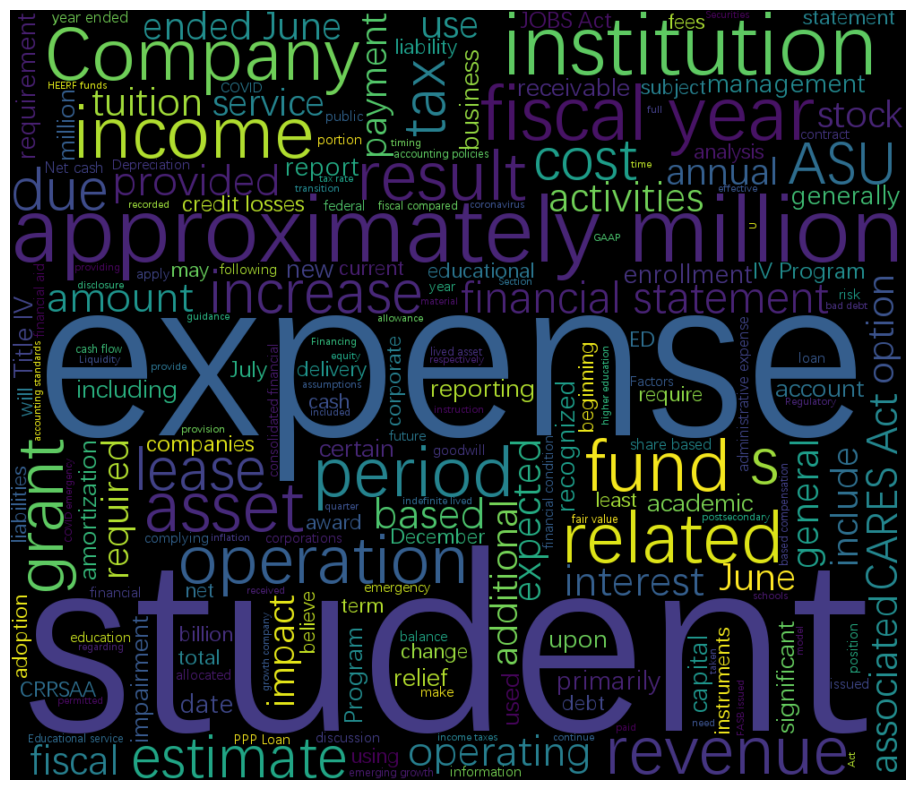

In [7]:
# Segment text content
token = nltk.word_tokenize(item17_df.loc[0, 'item7_text'])

page_text = ' '.join(token)
wordcloud = WordCloud(font_path="Deng.ttf", width=1000, height=860, ).generate(page_text)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

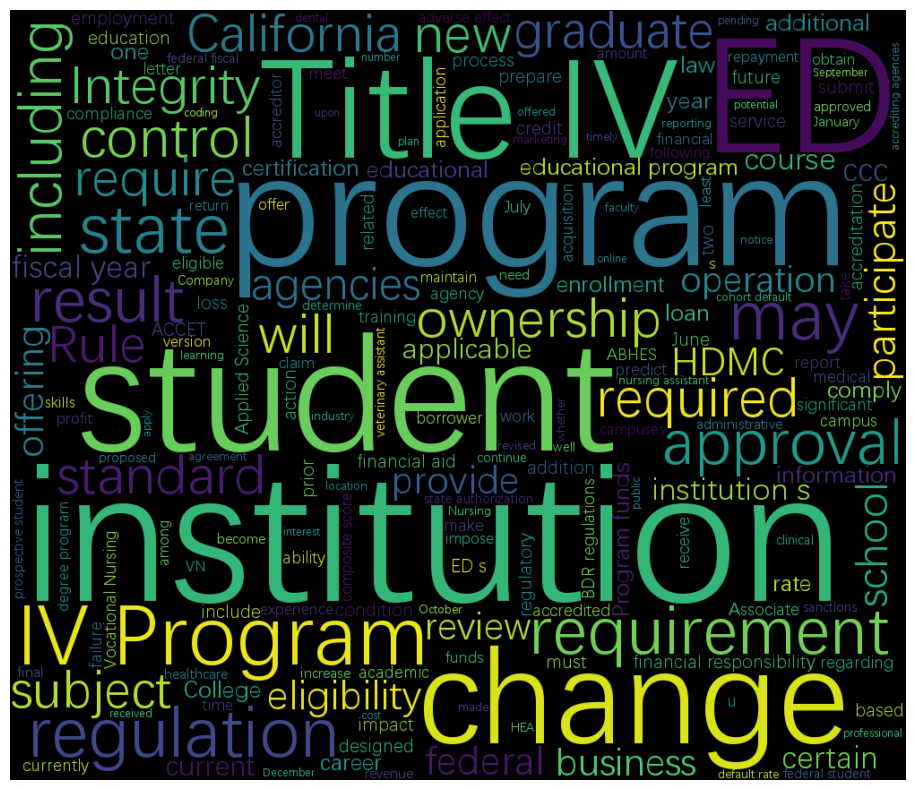

In [8]:
# Segment text content
token = nltk.word_tokenize(item17_df.loc[0, 'item1_text'])

page_text = ' '.join(token)
wordcloud = WordCloud(font_path="Deng.ttf", width=1000, height=860, ).generate(page_text)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
item17_df.loc[:, 'year'] = 2024

import os
from dotenv import load_dotenv

load_dotenv()

## use wrds package to connect to WRDS
import wrds
wrds_user = os.getenv("WRDS_USER")
db = wrds.Connection(wrds_username=wrds_user)

#    comp.company contains gvkey, company name (CONM), Company Legal Name (CONML), CIK, SIC, etc.
comp_cols = ['gvkey', 'conm', 'conml', 'cik', 'sic']
comp_company = db.get_table(library='comp', table='company', columns=comp_cols)
db.close()

# Normalize types
comp_company['cik'] = pd.to_numeric(comp_company['cik'], errors='coerce').astype('Int64')
comp_company['gvkey'] = comp_company['gvkey'].astype(int)
item17_df['cik'] = pd.to_numeric(item17_df['cik'], errors='coerce').astype('Int64')

# Keep only CIKs we actually need (speeds up & avoids noise)
target_ciks = item17_df['cik'].dropna().unique()
comp_company = comp_company[comp_company['cik'].isin(target_ciks)].copy()

# 3) De-duplicate: a CIK can map to multiple historical rows (name/brand changes, etc.)
# Preference rule (heuristic):
#   a) Prefer rows with a non-missing ticker
#   b) If multiple remain, take the one with the max gvkey (stable tie-breaker)
# You can replace this with a more sophisticated "active as of 2024" rule if needed.
comp_company = (
    comp_company
    .sort_values(['cik', 'gvkey'], ascending=[True, False])
    .drop_duplicates(subset=['cik'], keep='first')
)

# 4) Clean and rename for merge
comp_company = comp_company.rename(columns={
    'conm': 'firm_name',
    'tic': 'ticker',
    'sic': 'sic_code'
})

# SIC to 4-digit string (if you prefer zero-padded text)
comp_company['sic_code'] = pd.to_numeric(comp_company['sic_code'], errors='coerce').astype('Int64')

# 5) Left-join onto your extracted sections DataFrame
item17_with_comp = item17_df.merge(comp_company[['cik', 'gvkey', 'firm_name', 'sic_code']],
                                   on='cik', how='left')

# 6) Persist for reuse
item17_with_comp.to_pickle(r'.\data\l6\item17_df.pkl')


Loading library list...
Done


# Task 2 — Tokenize and Clean MD&A Text

**Goal:**  
Convert the raw “Item 7 – MD&A” text into a sequence of clean, meaningful tokens for NLP analysis.

---

## Steps Overview

1. **Tokenization**
   - Use `nltk.word_tokenize()` to split text into individual tokens (words, numbers, punctuation marks).
   - Example:  
     `"The company’s revenue increased by 10%. "` →  
     `['The', 'company', '’', 's', 'revenue', 'increased', 'by', '10', '%', '.']`

2. **Stopword and punctuation removal**
   - Load English stopwords from `nltk.corpus.stopwords`.
   - Remove all punctuation symbols (e.g., `"!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"`).
   - Filter the token list so that only informative words remain.

3. **Example run**
   - Demonstrate the process using one firm’s MD&A text (`item17_df.loc[0, 'item7_text']`).
   - Compare raw vs. filtered token lists to illustrate how much noise is reduced.

4. **Outcome**
   - Produces a cleaned token list (`token_filtered`) ready for:
     - Word frequency counts,
     - Sentiment scoring,
     - TF–IDF or embedding construction in later tasks.

> Note: Keep punctuation and stopword lists flexible — financial texts often include domain-specific stopwords (e.g., “million”, “company”, “fiscal”) which can be removed in the next refinement step.


In [53]:
import string

item7_token = nltk.word_tokenize(item17_df.loc[0, 'item7_text'])

# remove stop words and punctuation
stop_words = stopwords.words('english')
punc_list = string.punctuation
print(punc_list)  # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

example_content = item17_with_comp.iloc[0]['item7_text']
token_filtered = [x for x in item7_token if x not in punc_list and x not in stop_words]

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


# Task 3 — Compute Sentiment Scores from MD&A using Loughran–McDonald Dictionary

**Objective:**  
Quantify the *tone* of each firm’s MD&A section using the **Loughran–McDonald (LM) Master Dictionary**, a finance-specific sentiment lexicon widely used in accounting and finance research.

---

## Steps Overview

1. **Load sentiment dictionary**
   - Import the *Loughran–McDonald Master Dictionary (1993–2024)*.
   - Extract two word lists:
     - `p_dict_lm`: words labeled as **Positive** in the dictionary.  
     - `n_dict_lm`: words labeled as **Negative** in the dictionary.  
   - These will serve as our lookup lists for tone classification.

2. **Define helper functions**
   - `count_words()` — counts how many tokens in a text match the sentiment list.  
   - `get_words()` — retrieves all matching sentiment words (for inspection).  
   - `get_sentiment_score()` — tokenizes and cleans each MD&A, then:
     - Calculates **positive_rate** = (# positive words / total tokens)  
     - Calculates **negative_rate** = (# negative words / total tokens)  
     - Derives **sentiment_score** = positive_rate − negative_rate.

3. **Apply to all MD&A texts**
   - Iterate through each firm’s MD&A (`item17_with_comp['item7_text']`).
   - Store three new columns:
     - `item7_sentiment` — net tone (positive − negative).  
     - `item7_positive_rate` — fraction of positive words.  
     - `item7_negative_rate` — fraction of negative words.

4. **Interpretation**
   - Higher `item7_sentiment` → more optimistic tone.  
   - Lower (negative) values → more pessimistic tone.  
   - These measures are commonly used as proxies for managerial optimism or disclosure tone in finance literature (e.g., *Loughran & McDonald, JF 2011*).

5. **Next steps**
   - Examine the distribution of sentiment scores across firms.  
   - Compare tone with firm characteristics (size, SIC, performance) or stock returns in later sections.

> ⚙️ *Tip:* The LM dictionary is case-insensitive and specialized for financial context, avoiding misclassifications (e.g., “liability”, “capital”) common in general-purpose sentiment dictionaries.


In [50]:
# --- Sentiment dictionary loading (notebook cell) ---
sentiment_dict_lm = pd.read_csv(os.path.join('.', 'data', 'l6', 'Loughran-McDonald_MasterDictionary_1993-2024.csv'))
p_dict_lm = sentiment_dict_lm[sentiment_dict_lm['Positive'] != 0]['Word'].to_list()
n_dict_lm = sentiment_dict_lm[sentiment_dict_lm['Negative'] != 0]['Word'].to_list()

In [57]:
import numpy as np

def count_words(words_list, in_sentiment_words):
    result = np.zeros([len(in_sentiment_words)])
    for word in words_list:
        if word.upper() in in_sentiment_words:
            _index = in_sentiment_words.index(word.upper())
            result[_index] += 1
    return result


def get_words(words_list, in_sentiment_words):
    result = []
    for word in words_list:
        if word.upper() in in_sentiment_words:
            result.append(word.lower())
    return result

def get_sentiment_score(content):
    token = nltk.word_tokenize(content)
    token_filtered = [x for x in token if x not in punc_list and x not in stop_words]
    p_res = count_words(token_filtered, p_dict_lm)
    n_res = count_words(token_filtered, n_dict_lm)

    positive_rate = p_res.sum() / len(token_filtered)
    negative_rate = n_res.sum() / len(token_filtered)

    page_sentiment = positive_rate - negative_rate
    return page_sentiment, positive_rate, negative_rate


In [58]:
item17_with_comp.loc[:, 'item7_sentiment'] = np.nan
item17_with_comp.loc[:, 'item7_positive_rate'] = np.nan
item17_with_comp.loc[:, 'item7_negative_rate'] = np.nan

item17_with_comp.loc[:, 'item7_sentiment'], item17_with_comp.loc[:, 'item7_positive_rate'], item17_with_comp.loc[:, 'item7_negative_rate'] = zip(*item17_with_comp['item7_text'].map(get_sentiment_score))

In [60]:
item17_with_comp.head()

,filename,cik,item7_text,item1_text,year,gvkey,firm_name,sic_code,item7_sentiment,item7_positive_rate,item7_negative_rate
0,0001493152-24-038926,1836754,ITEM\r\n7. MANAGEMENT S DISCUSSION AND ANALYSI...,ITEM\r\n1. BUSINESS \r\n\r\nOverview \r\n\r\nW...,2024,50478.0,LEGACY EDUCATION INC,8200,-0.011010,0.007124,0.018135
1,0001493152-24-038852,69422,Item 7. Management s Discussion and Analysis o...,"Item\r\n10. Directors, Executive Officers and ...",2024,7632.0,INTERGROUP CORP,7011,-0.019695,0.009197,0.028893
2,0001683168-24-006824,1624985,ITEM 7. \r\n MANAGEMENT S DISCUSSION AND ANALY...,ITEM 10. \r\n DIRECTORS AND EXECUTIVE OFFICERS...,2024,NaN,<NA>,<NA>,-0.011890,0.011264,0.023154
3,0001885849-24-000015,1885849,Item 7. Management's Discussion and Analysis o...,"Item 10. Directors, Executive Officers, and Co...",2024,NaN,<NA>,<NA>,-0.012727,0.001818,0.014545
4,0001377789-24-000043,1377789,Item 7. Management s Discussion and Analysis o...,"Item 1. Business, Item 7. Management s Discuss...",2024,176572.0,AVIAT NETWORKS INC,3663,-0.034134,0.015723,0.049857


# Task 4 — Apply **FinBERT** for Contextual Sentiment Scoring of MD&A Sections

**Goal:**  
Generate advanced, *context-aware* sentiment measures using a pre-trained financial language model (FinBERT) to complement our earlier dictionary-based scores.

---

## Step-by-step summary

1. **Load FinBERT model**
   - Uses the `ProsusAI/finbert` checkpoint from Hugging Face, fine-tuned on financial news and filings.
   - Produces three sentiment probabilities per text: **positive**, **neutral**, and **negative**.
   - Sentiment is context-sensitive — FinBERT understands that “liability” or “debt issuance” are not necessarily negative in finance.

2. **Sentence tokenization & chunking**
   - 10-K texts are much longer than FinBERT’s 512-token limit.
   - The code splits each MD&A into sentences and groups them into token-length–bounded chunks (≈480 tokens) to ensure valid model input.

3. **Batch inference**
   - Each chunk is encoded and passed through FinBERT.
   - For efficiency, inference runs in small batches (`batch_size=8` by default).
   - If CUDA (GPU) is available, the model automatically runs on GPU.

4. **Aggregate chunk-level results**
   - FinBERT outputs logits for `[Negative, Neutral, Positive]`.
   - The notebook averages logits across all chunks in a document, converts them to probabilities, and computes:
     - `item7_finbert_pos` — average positive probability  
     - `item7_finbert_neu` — average neutral probability  
     - `item7_finbert_neg` — average negative probability  
     - `item7_finbert_score` — **net tone** = Positive − Negative (ranges from −1 to +1)

5. **Output integration**
   - Adds all FinBERT sentiment fields to the main DataFrame (`item17_with_comp`).
   - Displays example rows and summary statistics for a quick check.

6. **Interpretation**
   - **High FinBERT score (≈ +1):** Optimistic, confident tone.  
   - **Low FinBERT score (≈ −1):** Pessimistic, cautious, or uncertain tone.  
   - **Near 0:** Neutral disclosure tone.

> ⚙️ *Tips:*  
> - Use FinBERT scores for robustness checks or cross-validation with LM dictionary results.  
> - For longer documents, FinBERT often provides richer contextual understanding than simple word counts, especially when negation or financial jargon is present.


In [62]:
import math
import os
import gc
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

In [63]:
# Punkt is needed for sentence tokenization; newer NLTK may use "punkt" or "punkt_tab"
for pkg in ["punkt", "punkt_tab"]:
    try:
        nltk.data.find(f"tokenizers/{pkg}")
    except LookupError:
        nltk.download(pkg, quiet=True)

from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [64]:
# 1) Load FinBERT (finance-tuned sentiment classifier)
MODEL_NAME = "ProsusAI/finbert"  # alternative: "yiyanghkust/finbert-tone"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()

# FinBERT label mapping (ProsusAI/finbert: 0=negative, 1=neutral, 2=positive)
id2label = model.config.id2label
label2id = {v.lower(): k for k, v in id2label.items()}  # e.g., {"negative":0,"neutral":1,"positive":2}

NEG_ID = label2id.get("negative", 0)
NEU_ID = label2id.get("neutral", 1)
POS_ID = label2id.get("positive", 2)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

d:\anaconda3\envs\finnlp\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\wangy\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [65]:
# 2) Utilities: chunk long text into <= max_tokens segments to respect transformer limit
def _chunk_text_by_tokens(text: str, max_tokens: int = 480):
    """
    Split text into sentence groups so that each group is under `max_tokens` when tokenized.
    FinBERT max input is 512 tokens; we leave margin for special tokens.
    """
    if not isinstance(text, str) or not text.strip():
        return []

    sents = sent_tokenize(text)
    chunks, cur_chunk, cur_len = [], [], 0
    for s in sents:
        # estimate token length using tokenizer
        # (fast; we only need length, not actual ids here)
        tok_len = len(tokenizer.encode(s, add_special_tokens=False))
        if tok_len > max_tokens:  # very long sentence: hard truncate
            # split by words as a fallback
            words = s.split()
            # approximate 1 token per word (rough), further ensure limit
            for i in range(0, len(words), max_tokens):
                sub = " ".join(words[i:i+max_tokens])
                chunks.append(sub)
            cur_chunk, cur_len = [], 0
            continue

        if cur_len + tok_len <= max_tokens:
            cur_chunk.append(s)
            cur_len += tok_len
        else:
            if cur_chunk:
                chunks.append(" ".join(cur_chunk))
            cur_chunk = [s]
            cur_len = tok_len

    if cur_chunk:
        chunks.append(" ".join(cur_chunk))
    return chunks

@torch.no_grad()
def finbert_score_text(text: str,
                       batch_size: int = 8,
                       max_tokens: int = 480):
    """
    Return dict with averaged class probabilities and net score for a document:
      {
        'pos': float,
        'neu': float,
        'neg': float,
        'score': pos - neg,
        'n_chunks': int
      }
    """
    if not isinstance(text, str) or not text.strip():
        return {'pos': np.nan, 'neu': np.nan, 'neg': np.nan, 'score': np.nan, 'n_chunks': 0}

    chunks = _chunk_text_by_tokens(text, max_tokens=max_tokens)
    if len(chunks) == 0:
        return {'pos': np.nan, 'neu': np.nan, 'neg': np.nan, 'score': np.nan, 'n_chunks': 0}

    logits_list = []

    # batched inference
    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
        out = model(**enc)
        logits = out.logits.detach().cpu()  # shape [B, 3]
        logits_list.append(logits)

        # free cuda memory
        del enc, out
        if device == "cuda":
            torch.cuda.empty_cache()

    if not logits_list:
        return {'pos': np.nan, 'neu': np.nan, 'neg': np.nan, 'score': np.nan, 'n_chunks': 0}

    logits_all = torch.cat(logits_list, dim=0)            # [N_chunks, 3]
    mean_logits = logits_all.mean(dim=0, keepdim=True)    # [1, 3]
    probs = torch.softmax(mean_logits, dim=-1).squeeze(0) # [3]

    pos = float(probs[POS_ID])
    neu = float(probs[NEU_ID])
    neg = float(probs[NEG_ID])
    score = pos - neg

    return {'pos': pos, 'neu': neu, 'neg': neg, 'score': score, 'n_chunks': len(chunks)}


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
results = []
for txt in tqdm(item17_with_comp['item7_text'].fillna(""), desc="FinBERT scoring"):
    results.append(finbert_score_text(txt))

finbert_df = pd.DataFrame(results)
item17_with_comp[['item7_finbert_pos', 'item7_finbert_neu', 'item7_finbert_neg', 'item7_finbert_score', 'item7_finbert_chunks']] = \
    finbert_df[['pos', 'neu', 'neg', 'score', 'n_chunks']].values



Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
FinBERT scoring: 100%|██████████| 205/205 [23:22<00:00,  6.84s/it]



[FinBERT] Example rows:


KeyError: "['ticker'] not in index"

In [67]:
# 4) Quick diagnostics
print("\n[FinBERT] Example rows:")
display(item17_with_comp[['firm_name','sic_code','item7_finbert_pos','item7_finbert_neu','item7_finbert_neg','item7_finbert_score']].head(5))


[FinBERT] Example rows:


,firm_name,sic_code,item7_finbert_pos,item7_finbert_neu,item7_finbert_neg,item7_finbert_score
0,LEGACY EDUCATION INC,8200,0.059617,0.858023,0.082360,-0.022743
1,INTERGROUP CORP,7011,0.051379,0.836849,0.111772,-0.060393
2,<NA>,<NA>,0.053411,0.810160,0.136429,-0.083017
3,<NA>,<NA>,0.067535,0.845374,0.087091,-0.019556
4,AVIAT NETWORKS INC,3663,0.075605,0.639013,0.285382,-0.209778


In [68]:
print("\n[FinBERT] Summary:")
print(item17_with_comp['item7_finbert_score'].describe())


[FinBERT] Summary:
count    205.000000
mean      -0.119508
std        0.137277
min       -0.676526
25%       -0.194036
50%       -0.090140
75%       -0.020359
max        0.156695
Name: item7_finbert_score, dtype: float64


In [69]:
# Cleanup
gc.collect()
if device == "cuda":
    torch.cuda.empty_cache()

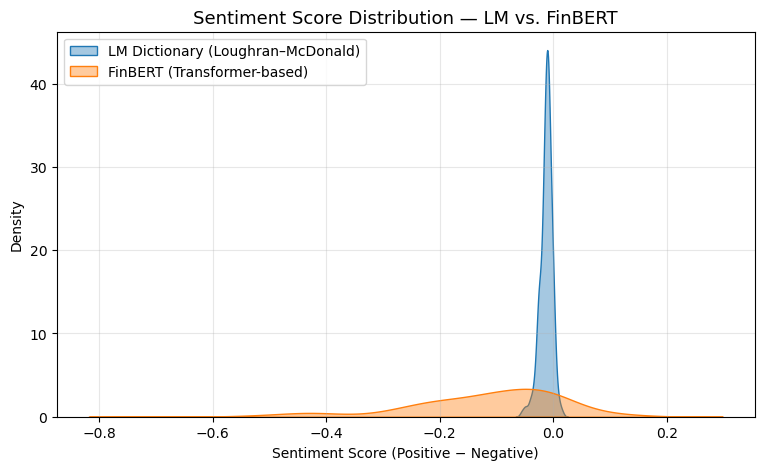

In [71]:
# --- Visualization: Compare LM dictionary vs. FinBERT sentiment scores ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Drop missing values for fair comparison
df_vis = item17_with_comp[['item7_sentiment', 'item7_finbert_score']].dropna().copy()

# 1. Distribution comparison (histogram / KDE)
plt.figure(figsize=(9, 5))
sns.kdeplot(df_vis['item7_sentiment'], label='LM Dictionary (Loughran–McDonald)', fill=True, alpha=0.4)
sns.kdeplot(df_vis['item7_finbert_score'], label='FinBERT (Transformer-based)', fill=True, alpha=0.4)
plt.title("Sentiment Score Distribution — LM vs. FinBERT", fontsize=13)
plt.xlabel("Sentiment Score (Positive − Negative)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


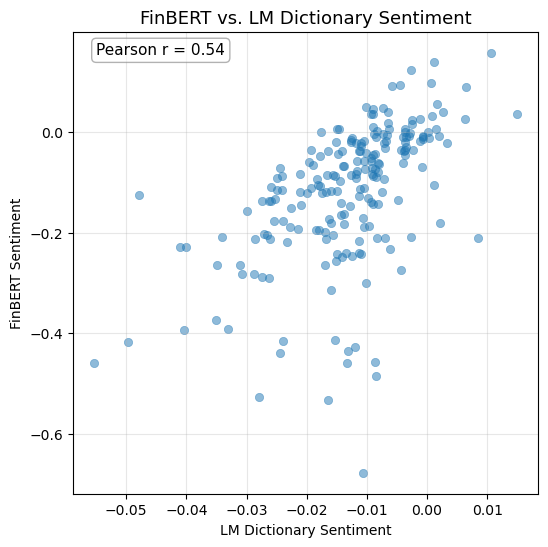

In [72]:

# 2. Scatter plot: FinBERT vs LM Dictionary
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_vis, x='item7_sentiment', y='item7_finbert_score', alpha=0.5, edgecolor=None)
plt.title("FinBERT vs. LM Dictionary Sentiment", fontsize=13)
plt.xlabel("LM Dictionary Sentiment")
plt.ylabel("FinBERT Sentiment")
plt.grid(alpha=0.3)

# Add correlation annotation
corr = np.corrcoef(df_vis['item7_sentiment'], df_vis['item7_finbert_score'])[0, 1]
plt.text(0.05, 0.95, f"Pearson r = {corr:.2f}", transform=plt.gca().transAxes,
         fontsize=11, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.6))
plt.show()

C:\Users\wangy\AppData\Local\Temp\ipykernel_21236\1068556702.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_vis.melt(var_name='Method', value_name='Score'),


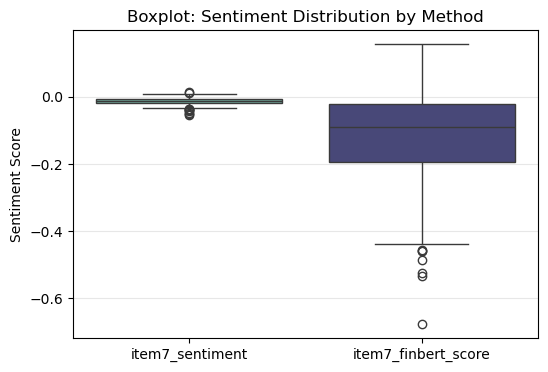

In [73]:
# 3. Boxplot comparison
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_vis.melt(var_name='Method', value_name='Score'),
            x='Method', y='Score', palette=['#69b3a2', '#404080'])
plt.title("Boxplot: Sentiment Distribution by Method")
plt.xlabel("")
plt.ylabel("Sentiment Score")
plt.grid(alpha=0.3, axis='y')
plt.show()